<a href="https://colab.research.google.com/github/huberyhub/himal_hubery_mateo_DP_Project/blob/main/NewTrainedModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MaxAbsScaler
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import GPT2Tokenizer, GPT2ForSequenceClassification, GPT2Config, AdamW
from sklearn.model_selection import train_test_split
from tqdm.auto import tqdm
from sklearn.metrics import balanced_accuracy_score

In this Jupyter Notebook, we are building a model to predict the movement of the Dow Jones Industrial Average (DJIA) based on daily news headlines.

We start by importing necessary libraries and modules. These include numpy for numerical operations, pandas for data manipulation, sklearn for preprocessing and model selection, torch for deep learning, transformers for the GPT-2 model, and tqdm for progress bars.

Next, we load and preprocess the dataset. The dataset is a CSV file named 'Combined_News_DJIA.csv'. Each record in the dataset consists of the date, the DJIA label (1 for increase, 0 for decrease), and 25 top news headlines for the day. We concatenate all the news headlines into a single string for each record.

We then split the dataset into a training set and a validation set using a 80-20 split.

In [ ]:
# Load and preprocess the dataset
data = pd.read_csv('Datasets/Combined_News_DJIA.csv')

# Concatenate all the news headlines into a single string for each record
# Optimized by directly using pandas functionality
data['All_Headlines'] = data.iloc[:, 2:].fillna('').apply(lambda x: ' '.join(x), axis=1)
train_df, val_df = train_test_split(data, test_size=0.2, random_state=42)

We define a custom Dataset class for tokenization and batching. This class takes in the headlines and labels, tokenizes the headlines using the GPT-2 tokenizer, and returns the input IDs, attention masks, and labels for each batch.

In [ ]:
# Define a custom Dataset class for tokenization and batching
class NewsDataset(Dataset):
    def __init__(self, headlines, labels, tokenizer, max_len):
        self.headlines = headlines
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.headlines)

    def __getitem__(self, item):
        headline = str(self.headlines[item])
        label = self.labels[item]

        encoding = self.tokenizer.encode_plus(
            headline,
            add_special_tokens=True,
            max_length=self.max_len,
            truncation=True,
            padding='max_length',
            return_attention_mask=True,
            return_tensors='pt',
        )

        return {
            'headline_text': headline,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

We create data loaders for batch processing. These data loaders take in a dataframe, a tokenizer, a maximum length for the headlines, and a batch size, and return a DataLoader object that can be used for training and evaluation.

In [ ]:
# Create data loaders for batch processing
def create_data_loader(df, tokenizer, max_len, batch_size):
    ds = NewsDataset(
        headlines=df['All_Headlines'].to_numpy(),
        labels=df['Label'].to_numpy(),
        tokenizer=tokenizer,
        max_len=max_len
    )

    return DataLoader(ds, batch_size=batch_size, num_workers=0)

tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
tokenizer.pad_token = tokenizer.eos_token  # Use EOS token as pad token

MAX_LEN = 128
BATCH_SIZE = 16

model = GPT2ForSequenceClassification.from_pretrained('gpt2', num_labels=2)
model.config.pad_token_id = model.config.eos_token_id  # Configuring pad token
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model.to(device)

optimizer = AdamW(model.parameters(), lr=2e-5)

train_data_loader = create_data_loader(train_df, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(val_df, tokenizer, MAX_LEN, BATCH_SIZE)

Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at gpt2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


We initialize the GPT-2 model for sequence classification with two labels, move it to the GPU if available, and define the AdamW optimizer for training.

The code below defines a function called train_epoch that performs training and evaluation on a machine learning model using a given data loader. It iterates over the data loader, computes the model's outputs, calculates the loss, updates the model's parameters through backpropagation, and returns the accuracy and average loss for the epoch.

In [ ]:
# Training function with model evaluation on validation data
def train_epoch(model, data_loader, optimizer, device, n_examples):
    model.train()
    losses = []
    correct_predictions = 0

    for d in tqdm(data_loader, desc="Training"):
        input_ids = d['input_ids'].to(device)
        attention_mask = d['attention_mask'].to(device)
        labels = d['labels'].to(device)

        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            labels=labels
        )

        loss = outputs.loss
        logits = outputs.logits
        _, preds = torch.max(logits, dim=1)
        correct_predictions += torch.sum(preds == labels)
        losses.append(loss.item())

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    return correct_predictions.double() / n_examples, np.mean(losses)

The code below is a training loop with early stopping for a machine learning model. It trains the model for a specified number of epochs and evaluates its performance on a validation dataset after each epoch. If the validation accuracy improves, the model's state is saved as the best model so far. If the validation accuracy does not improve for a certain number of epochs (defined by the early stopping limit), the training loop is stopped and the best model is reloaded. The code also includes the implementation of the train_epoch function, which performs one training epoch for the model using a data loader.

In [ ]:
# Define the eval_model function here
def eval_model(model, data_loader, device, n_examples):
    model.eval()
    losses = []
    correct_predictions = 0

    with torch.no_grad():
        for d in data_loader:
            input_ids = d['input_ids'].to(device)
            attention_mask = d['attention_mask'].to(device)
            labels = d['labels'].to(device)

            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                labels=labels
            )

            loss = outputs.loss
            logits = outputs.logits
            _, preds = torch.max(logits, dim=1)
            correct_predictions += torch.sum(preds == labels)
            losses.append(loss.item())

    return correct_predictions.double() / n_examples, np.mean(losses)


In [ ]:
# Set the number of epochs for training
EPOCHS = 10

# Initialize the best validation accuracy to 0
best_val_accuracy = 0

# Initialize the early stopping counter to 0
early_stopping_counter = 0

# Set the limit for early stopping
early_stopping_limit = 3

# Start the training loop
for epoch in range(EPOCHS):
    print(f'Epoch {epoch + 1}/{EPOCHS}')
    print('-' * 10)

    # Train the model for one epoch and get the training accuracy and loss
    train_acc, train_loss = train_epoch(
        model,
        train_data_loader,
        optimizer,
        device,
        len(train_df)
    )
    print(f'Train loss {train_loss} accuracy {train_acc}')

    # Evaluate the model on the validation data and get the validation accuracy and loss
    val_acc, val_loss = eval_model(
        model,
        val_data_loader,
        device,
        len(val_df)
    )
    print(f'Val loss {val_loss} accuracy {val_acc}')

    # If the validation accuracy is better than the best so far, save the model's state and reset the early stopping counter
    if val_acc > best_val_accuracy:
        torch.save(model.state_dict(), 'best_model_state.bin')
        best_val_accuracy = val_acc
        early_stopping_counter = 0
    else:
        # If the validation accuracy did not improve, increment the early stopping counter
        early_stopping_counter += 1

    # If the early stopping counter exceeds the limit, stop training and load the best model's state
    if early_stopping_counter > early_stopping_limit:
        print("Early stopping, reloading checkpoint model")
        model.load_state_dict(torch.load('best_model_state.bin'))
        break

Epoch 1/10
----------


Training: 100%|██████████| 100/100 [03:47<00:00,  2.28s/it]


Train loss 0.687165886759758 accuracy 0.5537397862979259
Val loss 0.7180005979537963 accuracy 0.4723618090452261
Epoch 2/10
----------


Training: 100%|██████████| 100/100 [03:34<00:00,  2.15s/it]


Train loss 0.6530856329202652 accuracy 0.6172218730358265
Val loss 0.7435610342025757 accuracy 0.4849246231155779
Epoch 3/10
----------


Training: 100%|██████████| 100/100 [03:38<00:00,  2.18s/it]


Train loss 0.5784229359030724 accuracy 0.7020741671904462
Val loss 0.8035862565040588 accuracy 0.4824120603015075
Epoch 4/10
----------


Training: 100%|██████████| 100/100 [03:37<00:00,  2.18s/it]


Train loss 0.44692241862416265 accuracy 0.7944688874921433
Val loss 0.8707500100135803 accuracy 0.4899497487437186
Epoch 5/10
----------


Training: 100%|██████████| 100/100 [03:36<00:00,  2.17s/it]


Train loss 0.2690195171907544 accuracy 0.8975487115021998
Val loss 1.0900764107704162 accuracy 0.4899497487437186
Epoch 6/10
----------


Training: 100%|██████████| 100/100 [03:34<00:00,  2.15s/it]


Train loss 0.15249558406881988 accuracy 0.950345694531741
Val loss 1.1220964288711548 accuracy 0.5
Epoch 7/10
----------


Training: 100%|██████████| 100/100 [03:35<00:00,  2.15s/it]


Train loss 0.08793571271002293 accuracy 0.9824010056568196
Val loss 1.5177232837677002 accuracy 0.4798994974874372
Epoch 8/10
----------


Training: 100%|██████████| 100/100 [03:34<00:00,  2.14s/it]


Train loss 0.05843898297753185 accuracy 0.9880578252671276
Val loss 1.5878902220726012 accuracy 0.46984924623115576
Epoch 9/10
----------


Training: 100%|██████████| 100/100 [03:33<00:00,  2.14s/it]


Train loss 0.04322270812932402 accuracy 0.9905719673161534
Val loss 1.6578028035163879 accuracy 0.46733668341708545
Epoch 10/10
----------


Training: 100%|██████████| 100/100 [03:50<00:00,  2.31s/it]


Train loss 0.034880156663712115 accuracy 0.9918290383406663
Val loss 1.8640478682518005 accuracy 0.45979899497487436
Early stopping, reloading checkpoint model


In [ ]:
# Evaluation function and accuracy calculation
def evaluate(model, data_loader, device):
    # Set the model to evaluation mode
    model.eval()

    # Initialize lists to store predictions and real values
    predictions = []
    real_values = []

    # Disable gradient calculations
    with torch.no_grad():
        # Iterate over batches from the data loader
        for d in data_loader:
            # Move input and attention mask to device
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)

            # Get model outputs
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask
            )

            # Get the predicted class with the highest probability
            _, preds = torch.max(outputs.logits, dim=1)

            # Add the predictions and real values to their respective lists
            predictions.extend(preds)
            real_values.extend(d["labels"])

    # Convert lists to tensors and move them to CPU
    predictions = torch.stack(predictions).cpu()
    real_values = torch.stack(real_values).cpu()

    # Return predictions and real values
    return predictions, real_values

Balanced Accuracy Score (Validation): 0.5082953345183812


## Evaluation

Evaluation Report seeing balanced accuracy score, and test accuracy

In [ ]:
from sklearn.metrics import accuracy_score, classification_report

# Load the best saved model (if early stopping occurred)
model.load_state_dict(torch.load('best_model_state.bin'))

# Test the best model to get the final classification report and accuracy
test_predictions, test_real_values = evaluate(model, val_data_loader, device)
print(classification_report(test_real_values, test_predictions))
print("Test Accuracy:", accuracy_score(test_real_values, test_predictions))

# Calculate the balanced accuracy score
val_predictions, val_real_values = evaluate(model, val_data_loader, device)

# Calculate and print the balanced accuracy score for the entire validation set
balanced_accuracy_val = balanced_accuracy_score(val_real_values.numpy(), val_predictions.numpy())
print("Balanced Accuracy Score (Validation):", balanced_accuracy_val)

              precision    recall  f1-score   support

           0       0.44      0.57      0.49       171
           1       0.58      0.45      0.51       227

    accuracy                           0.50       398
   macro avg       0.51      0.51      0.50       398
weighted avg       0.52      0.50      0.50       398

Test Accuracy: 0.5
Balanced Accuracy Score (Validation): 0.5082953345183812


Check examples on actual evaluations

In [ ]:
individual_predictions, individual_real_values = evaluate(model, test_data_loader, device)

# Print predictions and actual labels for individual headlines
for i in range(len(individual_predictions)):
    print(f"Headline: {test_sample['All_Headlines'].iloc[i]}")
    print(f"Predicted sentiment: {'Increase' if individual_predictions[i] == 1 else 'Decrease'}")
    print(f"Actual movement: {'Increase' if individual_real_values[i] == 1 else 'Decrease'}")
    print("---")

Headline: b'Greece: Union activist loses her eye in acid attack. Her supporters blockade company. Riot police "forced to run leaving shields, helmets and even shoes behind."' b'Israel has been in violation of international law since 1967, protected by the United States veto of UN Resolutions condemning Israel for its violent, inhumane, barbaric, and illegal acts.' b'Zbigniew Brzezinski to Joe Scarborough on Gaza: "You know, you have such a stunningly superficial knowledge of what went on that it\'s almost embarrassing to listen to you."' b'Iceland after the fall' b'Russia is to shut off gas supplies to Ukraine, raising fears of European energy shortages' b'Video about living conditions in Gaza (from 2007)' b'"Here is a simple, stone cold fact. You cannot read or hear the truth about what is happening in Gaza from any corporate media in the United States."' b'MP wins support to ban topless sunbathing on Aussie beaches' b"The IL Gov scandal is wrong, but almost EVERY election/bill/decisi

We can put in headline here our self and check the predicted result

In [ ]:
def predict_headline(model, tokenizer, headline, device, max_len=128):
    model.eval()  # Put the model in evaluation mode

    # Tokenizing the headline
    encoding = tokenizer.encode_plus(
        headline,
        add_special_tokens=True,
        max_length=max_len,
        truncation=True,
        padding='max_length',
        return_attention_mask=True,
        return_tensors='pt',
    )

    input_ids = encoding['input_ids'].to(device)
    attention_mask = encoding['attention_mask'].to(device)

    # Forward pass, get the logits
    with torch.no_grad():
        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask
        )

    # Convert logits to probabilities (optional)
    probabilities = torch.nn.functional.softmax(outputs.logits, dim=-1)

    # Get the predicted index
    predicted_index = torch.argmax(probabilities, dim=-1).item()
    predicted_probability = probabilities[:, predicted_index].item()

    return {
        'headline': headline,
        'prediction': 'Increase' if predicted_index == 1 else 'Decrease',
        'probability': predicted_probability
    }

# Example of testing an individual headline
headline = "Automobile Manufacturer Recalls Millions of Vehicles Over Safety Concerns."
result = predict_headline(model, tokenizer, headline, device)
print(f"Headline: {result['headline']}")
print(f"Predicted Movement: {result['prediction']}")
print(f"Prediction Probability: {result['probability']:.2f}")

# Major Bank Faces Regulatory Scrutiny Over Fraud Allegations. Tech Giant's Revenue Plummets Following Weak Quarterly Earnings Report.
# Global Markets Tumble Amidst Rising Geopolitical Tensions.
# Investor Confidence Hits New Low as Recession Fears Intensify. Cryptocurrency Exchange Files for Bankruptcy After Cyber Attack.
# Oil Prices Crash Due to Unexpected Surge in Global Supply. Retail Giant Closes Hundreds of Stores Nationwide Amid Sales Decline.
# Housing Market Slump Continues as Mortgage Rates Soar. Automobile Manufacturer Recalls Millions of Vehicles Over Safety Concerns.
# Start-Up Valuations Plummet as Venture Capital Funding Dries Up.


Headline: Automobile Manufacturer Recalls Millions of Vehicles Over Safety Concerns.
Predicted Movement: Increase
Prediction Probability: 0.94


## Use confusion matrix and ROC curve to visualize result

Classification Report:
               precision    recall  f1-score   support

           0       0.44      0.57      0.49       171
           1       0.58      0.45      0.51       227

    accuracy                           0.50       398
   macro avg       0.51      0.51      0.50       398
weighted avg       0.52      0.50      0.50       398

Accuracy Score: 0.5


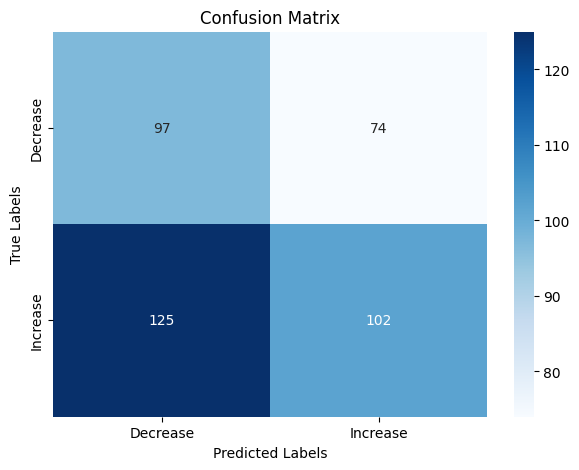

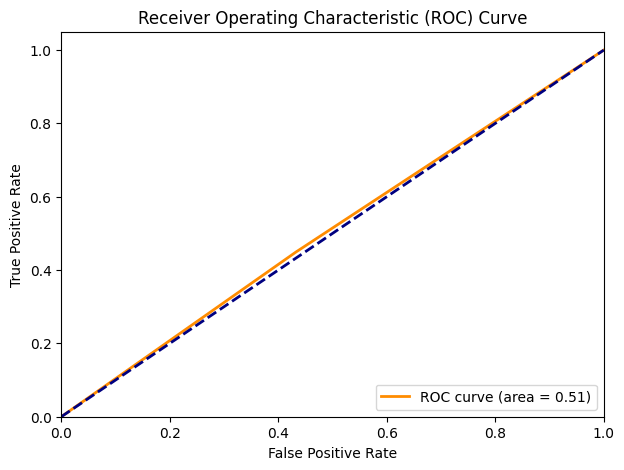

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, roc_curve, auc

def evaluate_and_visualize(model, data_loader, device):
    model.eval()
    predictions = []
    real_values = []

    with torch.no_grad():
        for d in data_loader:
            input_ids = d['input_ids'].to(device)
            attention_mask = d['attention_mask'].to(device)
            labels = d['labels'].to(device)

            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask
            )

            _, preds = torch.max(outputs.logits, dim=1)
            predictions.extend(preds.cpu().numpy())
            real_values.extend(labels.cpu().numpy())

    # Evaluation metrics
    print("Classification Report:\n", classification_report(real_values, predictions))
    print("Accuracy Score:", accuracy_score(real_values, predictions))

    # Confusion matrix
    cf_matrix = confusion_matrix(real_values, predictions)
    plt.figure(figsize=(7, 5))
    sns.heatmap(cf_matrix, annot=True, fmt='g', cmap='Blues', xticklabels=['Decrease', 'Increase'], yticklabels=['Decrease', 'Increase'])
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()

    # ROC Curve
    fpr, tpr, thresholds = roc_curve(real_values, predictions, pos_label=1)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(7, 5))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()

# Prepare the test data loader if not already done
# No need to define test_df, use val_df instead
test_data_loader = create_data_loader(val_df, tokenizer, MAX_LEN, BATCH_SIZE)
  # test_df needs to be defined

# Call the evaluation and visualization function
evaluate_and_visualize(model, test_data_loader, device)


# Some remarks and Next step

The performance of our model has been underwhelming, and we believe there are two primary reasons for this. Firstly, the inherent difficulty of the task cannot be overstated; we are dealing with a variety of daily headlines and the unpredictable nature of stock prices. Notably, our confusion matrix revealed that the model frequently misclassifies instances of stock price increases as decreases. This issue may stem from the general upward trend in stock indices during the training period, suggesting that the model lacks awareness of this long-term growth pattern. We need to explore strategies to incorporate this trend into the model's understanding.

Secondly, the architecture of the model itself might be contributing to the poor results. We are currently using GPT-2, which is primarily a decoder-based model, whereas the nature of our task aligns more closely with the functionalities of an encoder. In light of this, we plan to retrain our system using an encoder-based model like BERT to potentially improve its performance.

Should this adjustment prove effective, our next steps would include implementing inference optimization techniques we've studied in class. Additionally, we will conduct benchmarks across several models to determine the most effective one.

## Sentiment Analysis with BERT

This segment of the project introduces the use of the BERT (Bidirectional Encoder Representations from Transformers) model for sentiment analysis. BERT represents a breakthrough in the understanding of language representations and has proven effective across various NLP tasks, including sentiment analysis.

### BERT Model Overview

BERT differs from traditional transformer models by its architecture, which uses bidirectional training of Transformer, a popular attention model, to better capture the context of a word in relation to all the other words in a sentence, rather than only the words that precede it. This allows BERT to understand the context and nuances of language more effectively, making it well-suited for tasks involving understanding human language.

### Setup for BERT in the Pipeline

- **Model and Tokenizer Initialization**: We utilize `AutoTokenizer` and `AutoModelForSequenceClassification` from Hugging Face's `transformers` library. The `AutoModel` feature is particularly beneficial as it allows seamless switching between different model architectures. For testing the BERT model, we specify `MODEL_NAME` as `'bert-base-uncased'`. This automatically fetches the BERT tokenizer and model pre-configured for sequence classification tasks.

- **Data Preparation**: The BERT tokenizer is used to process the text data. It encodes the headlines into formats suitable for BERT, which involves converting sentences to token ids, segment ids, and attention masks. This preparation is crucial as BERT requires specific input formats to perform optimally.

### Testing the BERT Model

- **Training and Evaluation**: The script conducts training over a defined number of epochs, showing the loss and accuracy for each epoch. The BERT model is evaluated using a validation dataset, which helps monitor the model's performance and mitigate overfitting.

- **Performance Metrics**: After training, the BERT model is evaluated on the validation set to compute accuracy, generate a classification report, and calculate balanced accuracy. These metrics help assess how well the BERT model has learned to classify sentiments as either indicative of an increase or decrease in stock market trends based on the news headlines.

### Why BERT?

The choice to test BERT arises from its proven effectiveness in understanding context and nuances in text, making it a powerful tool for sentiment analysis. By leveraging BERT's capabilities, this project aims to explore how well it can translate these capabilities into predicting stock market trends, a task that heavily depends on interpreting the sentiment conveyed by news headlines.

### Flexibility of the Script

The script's design allows for easy swapping between different models such as GPT-2 and BERT without extensive modifications. This flexibility is vital for comparing different models' effectiveness on the same task, providing insights into which model architecture might be more suitable for analyzing sentiments in financial news.

This detailed examination and testing of the BERT model highlight its role and expected impact on the project, providing a robust framework for evaluating its performance against other advanced models like GPT-2.


In [ ]:
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModelForSequenceClassification, AdamW
from sklearn.model_selection import train_test_split
from tqdm.auto import tqdm
from sklearn.metrics import accuracy_score, classification_report, balanced_accuracy_score

# Parameters
MAX_LEN = 128
BATCH_SIZE = 16
EPOCHS = 10
MODEL_NAME = 'bert-base-uncased'  # Can change to 'gpt2', 'bert-base-uncased', etc.

# Load and preprocess the dataset
data = pd.read_csv('Datasets/Combined_News_DJIA.csv')
data['All_Headlines'] = data.iloc[:, 2:].fillna('').apply(lambda x: ' '.join(x), axis=1)
train_df, val_df = train_test_split(data, test_size=0.2, random_state=42)

# Define a custom Dataset class for tokenization and batching
class NewsDataset(Dataset):
    def __init__(self, headlines, labels, tokenizer, max_len):
        self.headlines = headlines
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.headlines)

    def __getitem__(self, item):
        headline = str(self.headlines[item])
        label = self.labels[item]

        encoding = self.tokenizer.encode_plus(
            headline,
            add_special_tokens=True,
            max_length=self.max_len,
            truncation=True,
            padding='max_length',
            return_attention_mask=True,
            return_tensors='pt',
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

# Initialize tokenizer and model
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=2)
model.to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))

# Create data loaders
def create_data_loader(df, tokenizer, max_len, batch_size):
    ds = NewsDataset(
        headlines=df['All_Headlines'].to_numpy(),
        labels=df['Label'].to_numpy(),
        tokenizer=tokenizer,
        max_len=max_len
    )
    return DataLoader(ds, batch_size=batch_size, num_workers=0)

train_data_loader = create_data_loader(train_df, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(val_df, tokenizer, MAX_LEN, BATCH_SIZE)

# Training and evaluation functions
def train_epoch(model, data_loader, optimizer, device):
    model.train()
    total_loss = 0
    total_accuracy = 0

    for d in tqdm(data_loader):
        input_ids = d['input_ids'].to(device)
        attention_mask = d['attention_mask'].to(device)
        labels = d['labels'].to(device)

        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs[0]
        logits = outputs[1]
        _, preds = torch.max(logits, dim=1)
        accuracy = (preds == labels).float().mean()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        total_accuracy += accuracy.item()

    return total_loss / len(data_loader), total_accuracy / len(data_loader)

def evaluate_model(model, data_loader, device):
    model.eval()
    predictions = []
    real_values = []

    with torch.no_grad():
        for d in data_loader:
            input_ids = d['input_ids'].to(device)
            attention_mask = d['attention_mask'].to(device)
            labels = d['labels'].to(device)

            outputs = model(input_ids, attention_mask=attention_mask)
            _, preds = torch.max(outputs.logits, dim=1)

            predictions.extend(preds.tolist())  # Convert tensor to list and store
            real_values.extend(labels.tolist())  # Convert tensor to list and store

    return predictions, real_values

# Setup optimizer
optimizer = AdamW(model.parameters(), lr=5e-5)

# Training loop
for epoch in range(EPOCHS):
    print(f'Epoch {epoch+1}/{EPOCHS}')
    train_loss, train_acc = train_epoch(model, train_data_loader, optimizer, model.device)
    print(f'Train Loss: {train_loss} Accuracy: {train_acc}')

    val_loss, val_acc = evaluate_model(model, val_data_loader, model.device)
    print(f'Validation Loss: {val_loss} Accuracy: {val_acc}')

# Final evaluation
predictions, real_values = evaluate_model(model, val_data_loader, model.device)
print("Final Validation Accuracy:", accuracy_score(real_values, predictions))
print("Classification Report:\n", classification_report(real_values, predictions))
print("Balanced Accuracy Score:", balanced_accuracy_score(real_values, predictions))

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:521: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/10


  0%|          | 0/100 [00:00<?, ?it/s]

Train Loss: 0.6938289105892181 Accuracy: 0.5246428573131561
Validation Loss: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

  0%|          | 0/100 [00:00<?, ?it/s]

Train Loss: 0.6934526199102402 Accuracy: 0.5279464292526245
Validation Loss: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

  0%|          | 0/100 [00:00<?, ?it/s]

Train Loss: 0.6912731575965881 Accuracy: 0.5332142859697342
Validation Loss: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

  0%|          | 0/100 [00:00<?, ?it/s]

Train Loss: 0.6809803909063339 Accuracy: 0.5494642859697342
Validation Loss: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0

  0%|          | 0/100 [00:00<?, ?it/s]

Train Loss: 0.6229808872938156 Accuracy: 0.6302678573131562
Validation Loss: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

  0%|          | 0/100 [00:00<?, ?it/s]

Train Loss: 0.5848143631219864 Accuracy: 0.6779464292526245
Validation Loss: [1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0

  0%|          | 0/100 [00:00<?, ?it/s]

Train Loss: 0.47824694715440275 Accuracy: 0.7798214292526245
Validation Loss: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

  0%|          | 0/100 [00:00<?, ?it/s]

Train Loss: 0.32369750797748564 Accuracy: 0.85875
Validation Loss: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

  0%|          | 0/100 [00:00<?, ?it/s]

Train Loss: 0.2515752194821835 Accuracy: 0.9138392859697342
Validation Loss: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1

  0%|          | 0/100 [00:00<?, ?it/s]

Train Loss: 0.1590016476623714 Accuracy: 0.94
Validation Loss: [1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 

In [ ]:
# Final evaluation
predictions, real_values = evaluate_model(model, val_data_loader, model.device)
print("Final Validation Accuracy:", accuracy_score(real_values, predictions))
print("Classification Report:\n", classification_report(real_values, predictions))
print("Balanced Accuracy Score:", balanced_accuracy_score(real_values, predictions))

Final Validation Accuracy: 0.5778894472361809
Classification Report:
               precision    recall  f1-score   support

           0       0.57      0.08      0.13       171
           1       0.58      0.96      0.72       227

    accuracy                           0.58       398
   macro avg       0.57      0.52      0.43       398
weighted avg       0.57      0.58      0.47       398

Balanced Accuracy Score: 0.5159852641883711


# Confusion Matrix
A confusion matrix provides a detailed breakdown of prediction results and errors, showing how well the model can distinguish between classes.

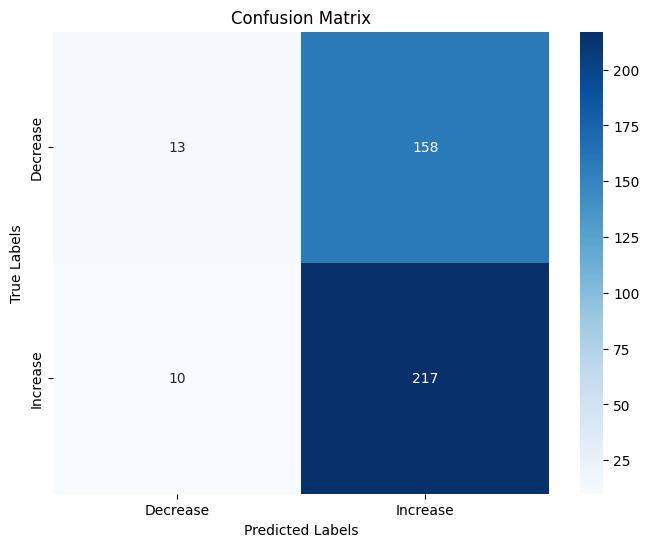

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

def plot_confusion_matrix(real_values, predictions):
    cm = confusion_matrix(real_values, predictions)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Decrease', 'Increase'], yticklabels=['Decrease', 'Increase'])
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()

plot_confusion_matrix(real_values, predictions)

# ROC Curve and AUC
The Receiver Operating Characteristic (ROC) curve and the Area Under the Curve (AUC) provide insights into the trade-off between true positive rate and false positive rate, offering a measure of model performance across different threshold settings.

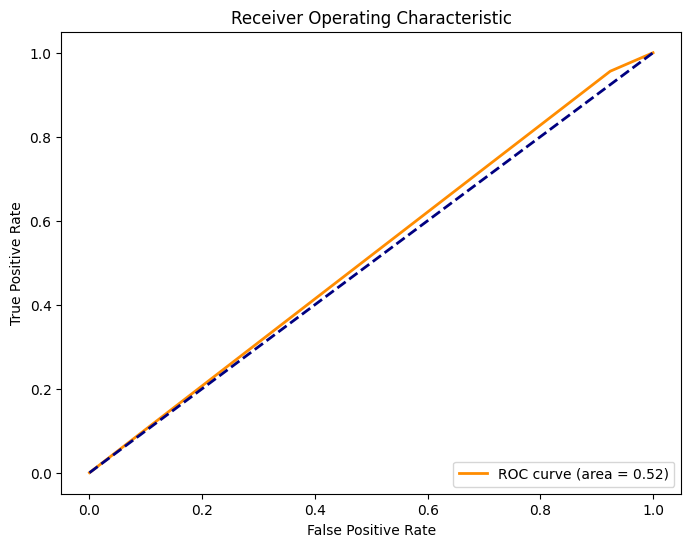

In [ ]:
from sklearn.metrics import roc_curve, auc

def plot_roc_curve(real_values, predictions):
    fpr, tpr, _ = roc_curve(real_values, predictions)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()

plot_roc_curve(real_values, predictions)


# 3. Precision-Recall Curve
This curve is useful especially when classes are very imbalanced. It focuses on the relationship between the true positive rate (recall) and the positive predictive value (precision).

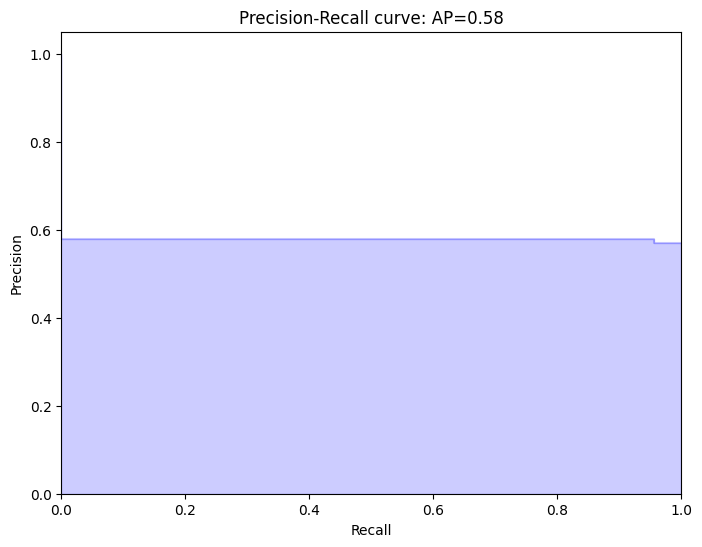

In [ ]:
from sklearn.metrics import precision_recall_curve, average_precision_score

def plot_precision_recall_curve(real_values, predictions):
    precision, recall, _ = precision_recall_curve(real_values, predictions)
    average_precision = average_precision_score(real_values, predictions)

    plt.figure(figsize=(8, 6))
    plt.step(recall, precision, color='b', alpha=0.2, where='post')
    plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title('Precision-Recall curve: AP={0:0.2f}'.format(average_precision))
    plt.show()

plot_precision_recall_curve(real_values, predictions)


#Other Models

In [2]:
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModelForSequenceClassification, AdamW
from sklearn.model_selection import train_test_split
from tqdm.auto import tqdm
from sklearn.metrics import accuracy_score, classification_report, balanced_accuracy_score

# Parameters
MAX_LEN = 128
BATCH_SIZE = 16
EPOCHS = 10
MODEL_NAME = 'roberta-base'  # Can change to 'gpt2', 'bert-base-uncased', etc.

# Load and preprocess the dataset
data = pd.read_csv('Datasets/Combined_News_DJIA.csv')
data['All_Headlines'] = data.iloc[:, 2:].fillna('').apply(lambda x: ' '.join(x), axis=1)
train_df, val_df = train_test_split(data, test_size=0.2, random_state=42)

# Define a custom Dataset class for tokenization and batching
class NewsDataset(Dataset):
    def __init__(self, headlines, labels, tokenizer, max_len):
        self.headlines = headlines
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.headlines)

    def __getitem__(self, item):
        headline = str(self.headlines[item])
        label = self.labels[item]

        encoding = self.tokenizer.encode_plus(
            headline,
            add_special_tokens=True,
            max_length=self.max_len,
            truncation=True,
            padding='max_length',
            return_attention_mask=True,
            return_tensors='pt',
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

# Initialize tokenizer and model
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=2)
model.to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))

# Create data loaders
def create_data_loader(df, tokenizer, max_len, batch_size):
    ds = NewsDataset(
        headlines=df['All_Headlines'].to_numpy(),
        labels=df['Label'].to_numpy(),
        tokenizer=tokenizer,
        max_len=max_len
    )
    return DataLoader(ds, batch_size=batch_size, num_workers=0)

train_data_loader = create_data_loader(train_df, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(val_df, tokenizer, MAX_LEN, BATCH_SIZE)

# Training and evaluation functions
def train_epoch(model, data_loader, optimizer, device):
    model.train()
    total_loss = 0
    total_accuracy = 0

    for d in tqdm(data_loader):
        input_ids = d['input_ids'].to(device)
        attention_mask = d['attention_mask'].to(device)
        labels = d['labels'].to(device)

        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs[0]
        logits = outputs[1]
        _, preds = torch.max(logits, dim=1)
        accuracy = (preds == labels).float().mean()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        total_accuracy += accuracy.item()

    return total_loss / len(data_loader), total_accuracy / len(data_loader)

def evaluate_model(model, data_loader, device):
    model.eval()
    predictions = []
    real_values = []

    with torch.no_grad():
        for d in data_loader:
            input_ids = d['input_ids'].to(device)
            attention_mask = d['attention_mask'].to(device)
            labels = d['labels'].to(device)

            outputs = model(input_ids, attention_mask=attention_mask)
            _, preds = torch.max(outputs.logits, dim=1)

            predictions.extend(preds.tolist())  # Convert tensor to list and store
            real_values.extend(labels.tolist())  # Convert tensor to list and store

    return predictions, real_values

# Setup optimizer
optimizer = AdamW(model.parameters(), lr=5e-5)

# Training loop
for epoch in range(EPOCHS):
    print(f'Epoch {epoch+1}/{EPOCHS}')
    train_loss, train_acc = train_epoch(model, train_data_loader, optimizer, model.device)
    print(f'Train Loss: {train_loss} Accuracy: {train_acc}')

    val_loss, val_acc = evaluate_model(model, val_data_loader, model.device)
    print(f'Validation Loss: {val_loss} Accuracy: {val_acc}')

# Final evaluation
predictions, real_values = evaluate_model(model, val_data_loader, model.device)
print("Final Validation Accuracy:", accuracy_score(real_values, predictions))
print("Classification Report:\n", classification_report(real_values, predictions))
print("Balanced Accuracy Score:", balanced_accuracy_score(real_values, predictions))

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:521: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/10


  0%|          | 0/100 [00:00<?, ?it/s]

Train Loss: 0.6933047109842301 Accuracy: 0.5332142859697342
Validation Loss: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

  0%|          | 0/100 [00:00<?, ?it/s]

Train Loss: 0.693546957373619 Accuracy: 0.5265178573131561
Validation Loss: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

  0%|          | 0/100 [00:00<?, ?it/s]

Train Loss: 0.6936097431182862 Accuracy: 0.5348214292526245
Validation Loss: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

  0%|          | 0/100 [00:00<?, ?it/s]

Train Loss: 0.6940173387527466 Accuracy: 0.5275892859697342
Validation Loss: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

  0%|          | 0/100 [00:00<?, ?it/s]

Train Loss: 0.6926609253883362 Accuracy: 0.5265178573131561
Validation Loss: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

  0%|          | 0/100 [00:00<?, ?it/s]

Train Loss: 0.6927081972360611 Accuracy: 0.5246428573131561
Validation Loss: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

  0%|          | 0/100 [00:00<?, ?it/s]

Train Loss: 0.6950220221281052 Accuracy: 0.5232142859697342
Validation Loss: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

  0%|          | 0/100 [00:00<?, ?it/s]

Train Loss: 0.6929276460409164 Accuracy: 0.5346428573131561
Validation Loss: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

  0%|          | 0/100 [00:00<?, ?it/s]

Train Loss: 0.6930731570720673 Accuracy: 0.5282142859697342
Validation Loss: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

  0%|          | 0/100 [00:00<?, ?it/s]

Train Loss: 0.6959170234203339 Accuracy: 0.5144642859697341
Validation Loss: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [3]:
# Final evaluation
predictions, real_values = evaluate_model(model, val_data_loader, model.device)
print("Final Validation Accuracy:", accuracy_score(real_values, predictions))
print("Classification Report:\n", classification_report(real_values, predictions))
print("Balanced Accuracy Score:", balanced_accuracy_score(real_values, predictions))

Final Validation Accuracy: 0.4296482412060301
Classification Report:
               precision    recall  f1-score   support

           0       0.43      1.00      0.60       171
           1       0.00      0.00      0.00       227

    accuracy                           0.43       398
   macro avg       0.21      0.50      0.30       398
weighted avg       0.18      0.43      0.26       398

Balanced Accuracy Score: 0.5


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


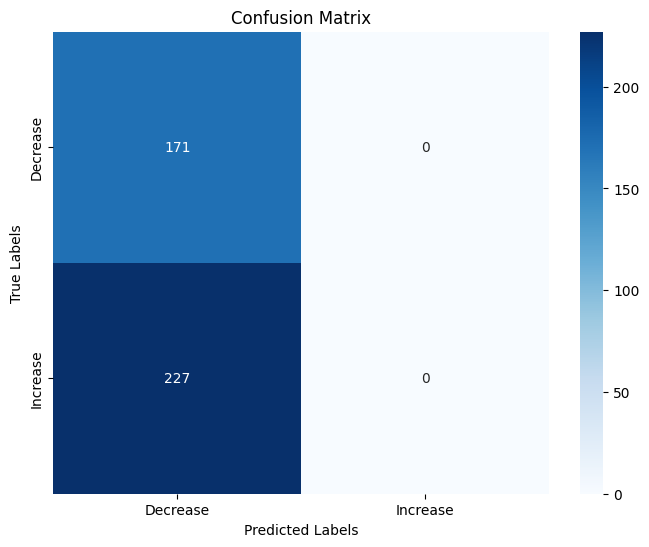

In [5]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

def plot_confusion_matrix(real_values, predictions):
    cm = confusion_matrix(real_values, predictions)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Decrease', 'Increase'], yticklabels=['Decrease', 'Increase'])
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()

plot_confusion_matrix(real_values, predictions)

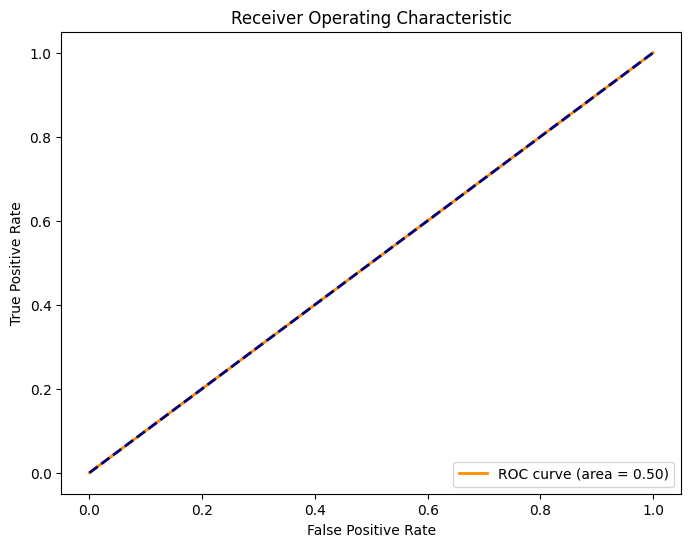

In [6]:
from sklearn.metrics import roc_curve, auc

def plot_roc_curve(real_values, predictions):
    fpr, tpr, _ = roc_curve(real_values, predictions)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()

plot_roc_curve(real_values, predictions)

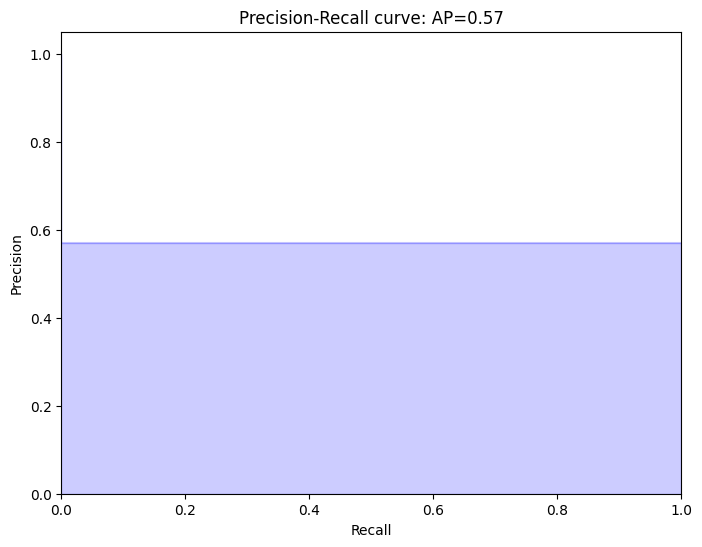

In [7]:
from sklearn.metrics import precision_recall_curve, average_precision_score

def plot_precision_recall_curve(real_values, predictions):
    precision, recall, _ = precision_recall_curve(real_values, predictions)
    average_precision = average_precision_score(real_values, predictions)

    plt.figure(figsize=(8, 6))
    plt.step(recall, precision, color='b', alpha=0.2, where='post')
    plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title('Precision-Recall curve: AP={0:0.2f}'.format(average_precision))
    plt.show()

plot_precision_recall_curve(real_values, predictions)